# Finding the exact Policy and Value functions in the MountainCar problem

The state space is discretized into a sufficiently large number of intervals along each axis. Then, from each discrete state, one environment step is launched for all possible actions. The following states are stored in the current state. Similarly, in each state, all previous states are remembered from which it can be reached.

The target states are placed in the FIFO queue and the value function for them is assumed to be -1. Then, for the previous states, the value function decreases by -1, and so on. The result is a value function for the entire space.

The agent's policy in each state is calculated using the value function. To do this, in the state, all possible actions are performed and the action with the maximum value is selected. If several actions result in the same maximum values, the policy function is considered undefined.

The resulting policy function is thinned out in areas continuously filled with the same actions. This simplifies the training of the neural network.

In [ ]:
import math
from   collections import deque
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

class MountainCar:
    """ 
    We simulate the MountainCar environment 
    https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py
    """
    def __init__(self, goal_velocity=0):
        self.min_position  = -1.2
        self.max_position  = 0.6
        self.max_speed     = 0.07
        self.goal_position = 0.5
        self.goal_velocity = goal_velocity

        self.low  = np.array([self.min_position, -self.max_speed], dtype=np.float32)
        self.high = np.array([self.max_position,  self.max_speed], dtype=np.float32)

        self.force   = 0.001
        self.gravity = 0.0025

        self.state = np.array([0., 0.])

    def step(self, action: int):
        position, velocity = self.state
        velocity += (action - 1) * self.force + math.cos(3 * position) * (-self.gravity)
        velocity = np.clip(velocity, -self.max_speed, self.max_speed)
        position += velocity
        position = np.clip(position, self.min_position, self.max_position)
        if position == self.min_position and velocity < 0:
            velocity = 0

        done = bool(position >= self.goal_position and velocity >= self.goal_velocity)

        self.state = (position, velocity)
        return np.array(self.state, dtype=np.float32), done

#===============================================================================

class Solver:
    def __init__(self, bins = (1001, 1001) ) -> None:
        self.bins = bins
        self.tot_bins = bins[0]*bins[1]
        self.env  = MountainCar()
        self.step = (self.env.high-self.env.low)/self.bins

    #---------------------------------------------------------------------------

    def state(self, indx):
        """ Get the state vector by its index (ix, iv) """
        return self.env.low + indx*self.step

    #---------------------------------------------------------------------------

    def index(self, state):
        """ Get state index (ix, iv) by its vector state """
        indx = ((state - self.env.low)/self.step).astype(np.int)
        indx = np.clip(indx, (0,0), (self.bins[0]-1, self.bins[1]-1))
        return tuple( indx )

    #---------------------------------------------------------------------------

    def x_v(self, i):
        """ i = x*bins[1] + v """
        x = i // self.bins[1]
        return x,  i - x * self.bins[1]      

    #---------------------------------------------------------------------------

    def create_graph(self):     
        """ Create a state transition graph """
        self.open  = deque()   
        self.prev, self.next = [], []
        for _ in range(self.tot_bins):
            self.prev.append([])
            self.next.append([])

        self.minV, goal  = -200, self.index([solver.env.goal_position, 0.])
        self.value = np.full(self.bins, self.minV)
        self.n_vals= 0

        for i1 in range(self.tot_bins):
            ix1, iv1 = self.x_v(i1)            
            s1  = self.state( (ix1, iv1) )
            for a in [0, 1, 2]:
                self.env.state = s1
                s2, done = self.env.step(a)
                ix2, iv2 = self.index(s2)
                i2 = ix2*self.bins[1] + iv2
                if i2 == i1:
                    continue
 
                self.next[i1].append( (i2, a) )
                self.prev[i2].append( i1 )
                if done and self.value[ix2, iv2] == self.minV:      
                    self.value[ix2, iv2] = -1
                    self.open.append(i2)
                    self.n_vals += 1
            if i1 % 1000 == 0:
                print(f"\rGraph : {i1*100./self.tot_bins:3.0f}%,  open len: {len(self.open):5d}", end="")
        print("\nGraph created")

    #---------------------------------------------------------------------------

    def calc_value(self):
        """ Calculate the value function from the transition graph """
        tot = self.bins[0]*self.bins[1]
        while self.open:
            i = self.open.popleft()
            for p in self.prev[i]:
                ipx, ipv = self.x_v(p)
                if self.value[ipx, ipv] == self.minV:
                    ix, iv = self.x_v(i)
                    self.value[ipx, ipv] = self.value[ix, iv] - 1
                    self.open.append(p)
                    self.n_vals += 1

            if self.n_vals % 100 == 0:
                print(f"\rNum values: {100.*self.n_vals/tot:5.2f}% open len: {len(self.open):5d}", end="")
        print(f"\rNum values: {100.*self.n_vals/tot:5.2f}% open len: {len(self.open):5d}")

    #---------------------------------------------------------------------------

    def calc_policy(self):
        """ Compute policy function using value function and transition graph """
        self.pi = np.full(self.bins, -1)
        wrong, equal, i = 0, 0, 0
        for ix in range(self.bins[0]):
            for iv in range(self.bins[1]):                
                maxV, maxA, cntMax = -10000, -1, 0
                res = []
                for n, a in self.next[i]:
                    nx, nv = self.x_v(n)
                    V = self.value[nx, nv]
                    if V > maxV:
                        maxA = a
                        maxV = V
                        cntMax = 1
                    elif V == maxV:
                        cntMax += 1

                if   cntMax == 0:
                    wrong += 1
                elif cntMax == 1:
                    self.pi[nx, nv] = maxA
                else:
                    equal += 1

                i += 1
                    
        print(f"Num policy wrong: {100.*wrong/self.pi.size:8.4f}%  equal: {100.*equal/self.pi.size:8.4f}%")

    #---------------------------------------------------------------------------

    def thin(self):
        """ Thin out policy function """
        for ix in range(1, self.bins[0]-1):
            for iv in range(1, self.bins[1]-1):
                a = self.pi[ix, iv] 
                if a != -1 and np.sum(self.pi[ix-1: ix+2, iv-1: iv+2]) == 9*a:
                    self.pi[ix, iv] = -1.

    #---------------------------------------------------------------------------

    def smooth(self, M):
        """ Smooth M-matrix """
        pool = nn.AvgPool2d(5, stride=1, padding = 2, count_include_pad=False)
        x = pool(torch.tensor(M, dtype=torch.float32).view(self.bins[0],self.bins[1], 1))        
        return torch.round(x.view(self.bins)).numpy()     

    #---------------------------------------------------------------------------

    def run(self):
        self.create_graph()
        self.calc_value()
        self.calc_policy()

    #---------------------------------------------------------------------------

    def test(self, episodes = 1000, ticks = 200):
        """ Testing with the current pi-function """
        env = gym.make("MountainCar-v0")
        rews = []
        for _ in range(episodes):
            obs =  env.reset()
            tot = 0
            for _ in range(ticks):
                indx   = self.index(obs)
                action = self.pi[indx]
                if action < 0:
                    action = 1
                obs, rew, done, _ = env.step(int(action))

                tot += rew
                if done:
                    break
            rews.append(tot)
        mean, std = np.mean(rews), np.std(rews)
        print(f"Reward: {mean:7.2f} ± {std/episodes**0.5:.1f}, std: {std:.0f}, min: {np.min(rews):.0f}  max: {np.max(rews):.0f}")

## Start of calculations

In our experiments we used bins = (5001, 5001). Building a graph takes a lot of time and requires a lot of CPU.

In [ ]:
solver = Solver(bins = (1001, 1001))

In [ ]:
solver.run()

If desired, the value function can be smoothed and the policy function calculated again.

In [ ]:
solver.value = solver.smooth(solver.value)
solver.calc_policy()

To train the neural network, we thin out the policy function in continuous areas.

In [ ]:
solver.thin()

## Saving and loading

In [ ]:
np.save("pi_smooth_thin",    solver.pi)

In [ ]:
np.save("pi_smooth",    solver.pi)
np.save("value_smooth", solver.value)

In [ ]:
solver.pi = np.load("pi_smooth_thin.npy")

## Visualization of policy and value functions

In [ ]:
from matplotlib import colors
cmap = colors.ListedColormap(['white', 'blue', 'green', 'red'])

def plot(mat, title, d_ticks=500, bins = (1001, 1001), bar = True, smooth = True):
    def index(state):
        step = (solver.env.high-solver.env.low)/bins
        indx = ((state - solver.env.low)/step).astype(np.int)
        indx = np.clip(indx, (0,0), (bins[0]-1, bins[1]-1))
        return tuple( indx )


    g, m   = index([solver.env.goal_position, 0.]), index([-math.pi/6, 0.])
    x0 = np.array([ index([-0.6, 0.]), index([-0.4, 0.]) ])

    if smooth:
        cmap = 'seismic'
    else:
        cmap = colors.ListedColormap(['gray', 'blue', 'white', 'red'])
        #cmap = colors.ListedColormap(['blue', 'white', 'red'])

    plt.figure(figsize=(8,8))
    plt.imshow(mat.T, interpolation='none', origin='lower', cmap= cmap, alpha=0.5)

    plt.title (title, {'fontsize': 16})
    plt.xlabel('x', {'fontsize': 16}) 
    plt.ylabel('v', {'fontsize': 16}) 
    plt.axhline(g[1], c="black", linewidth=1)
    plt.axvline(g[0], c="black", linewidth=1)
    plt.axvline(m[0], c="black", linewidth=1)
    plt.axvline(x0[0][0], c="black", linewidth=2, ymin = 0.49, ymax = 0.51)
    plt.axvline(x0[1][0], c="black", linewidth=2, ymin = 0.49, ymax = 0.51)
    ticks = range(0, bins[0], d_ticks)
    plt.xticks( ticks, np.round(100*np.linspace(solver.env.low[0], solver.env.high[0], len(ticks)))/100 )
    plt.yticks( ticks, np.round(100*np.linspace(solver.env.low[1], solver.env.high[1], len(ticks)))/100 )
    if bar:
      plt.colorbar(aspect=50) 
    plt.show()

In [ ]:
print(np.sum(solver.pi == 0), np.sum(solver.pi == 1), np.sum(solver.pi == 2))

plot(solver.pi, 'Policy function', d_ticks=500,  bins = (1001, 1001), smooth=False)

In [ ]:
plot(solver.value, 'Value function', d_ticks=500, bins = (1001, 1001))

In [ ]:
X = np.linspace(solver.env.low[0], solver.env.high[0], solver.bins[0])
Y = np.linspace(solver.env.low[1], solver.env.high[1], solver.bins[0])
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

surf = ax.plot_surface(X, Y, solver.value, cmap=plt.get_cmap('seismic'), linewidth=0, antialiased=True)
ax.view_init(-120, 30)

fig.colorbar(surf, shrink=0.5, aspect=50)

plt.show()

# Learning policy-function: Neural network with one output (sigmoid)

## Generate from policy

In [ ]:
def dataset():
    X, Y = [], []
    pi = solver.pi
    for ix in range(1, solver.bins[0]-1):
        for iv in range(1, solver.bins[1]-1):
            a = pi[ix, iv]
            if a != -1:                
                  X.append( solver.state((ix, iv)).tolist() )
                  Y.append( float(pi[ix, iv])/2. )               # !!!!! [0,2] -> [0,1]
    return X, Y

In [ ]:
solver.prev, solver.next = [], []    # clear memory

X, Y = dataset()
X, Y = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32).view(-1,1)

print(X[-3:])
print(Y[-3:])

print(torch.min(Y), torch.max(Y), len(Y), torch.sum(Y == 1.), torch.sum( Y == 0.))

data = torch.cat([X, Y], 1)
np.save("data_XY", data.numpy())
del data

## Load from file

In [ ]:
data = np.load("MountainCar_data_XY.npy")
X = torch.tensor(data[:, 0:2], dtype=torch.float32)
Y = torch.tensor(data[:, 2: ], dtype=torch.float32)

print(X[-3:])
print(Y[-3:])

print(X.size())
print(torch.min(Y), torch.max(Y), len(Y), torch.sum(Y == 1.), torch.sum( Y == 0.))

## Create divice

In [ ]:
import torch
import torch.nn as nn

gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(gpu)

In [ ]:
#low, high = torch.tensor([[-1.2, -0.07]]), torch.tensor([[0.5, 0.07]])
#X = 2.*(X - low)/(high-low) - 1.

## Network architecture

In [ ]:
nH = [128, 128]
model = nn.Sequential(           
           nn.Linear(2, nH[0]),    
           nn.Sigmoid(),         
           nn.Linear(nH[0], nH[1]),  
           nn.Sigmoid(),         
           nn.Linear(nH[1], 1),  
           nn.Sigmoid() )      
model.to(gpu) 
print(gpu)

## Learning

In [ ]:
loss      = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),   lr=0.1, momentum=0.8) 
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1 )

gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X = X.to(gpu)
Y = Y.to(gpu)

print(X.device, Y.device)

In [ ]:
def fit(model, X,Y, batch_size=1000, train=True):          
      model.train(train)                                   # important for Dropout, BatchNorm
      sumL, sumA, numB = 0, 0, int( len(X)/batch_size )    # error, accuracy, batches
       
      idx = torch.randperm( len(X) ).to(gpu)               # mix index list
      X, Y = X[idx], Y[idx]      

      for i in range(0, numB*batch_size, batch_size):          
          xb, yb = X[i: i+batch_size],  Y[i: i+batch_size]                                 
              
          y = model(xb)                                    # direct distribution
          L = loss(y, yb)                                  # calculate the loss
  
          if train:                                        # in learning mode
              optimizer.zero_grad()                        # reset the gradients        
              L.backward()                                 # calculate gradients            
              optimizer.step()                             # adjusting parameters
                                     
          sumL += L.detach().item()                        # total error (item from graph)
          sumA += (y.round() == yb).float().mean()         # class definition accuracy
         
      return sumL/numB,  sumA/numB                         # mean error and accuracy

In [ ]:
import time
model.to(gpu)
print( "before:      loss: %.5f accuracy: %.4f" %  fit(model, X,Y, train=False) )
 
beg = time.process_time()
epochs = 1000                                              # number of epochs
for epoch in range(epochs):                                
    L,A = fit(model, X, Y, batch_size=500)                 # one epoch
       
    if (epoch and epoch % 10 == 0) or epoch == epochs-1:  
        print(f"epoch: {epoch:5d} loss: {L:.5f} accuracy: {A:.4f}   {time.process_time()-beg:.2f}s")   
        beg = time.process_time()

## Testing a neural network on a real environment

In [ ]:
def test(model, episodes = 1000, ticks=200, level = 0.05):
    env = gym.make("MountainCar-v0")
    rews = []
    for episode in range(episodes):
        obs =  env.reset()
        tot = 0
        for _ in range(ticks):
            with torch.no_grad():
                #x = 2.*(torch.tensor(obs, dtype=torch.float32) - low)/(high-low) - 1.
                x = torch.tensor(obs, dtype=torch.float32)
                y = model(x)
            
            if   y > 0.5 + level:
                action = 2
            elif y < 0.5 - level:
                action = 0
            else:
                action = 1            

            obs, rew, done, _ = env.step(action)
            tot += rew

            if done:
                break

        rews.append(tot)
        if episode and episode % 100 == 0:
            mean, std = np.mean(rews), np.std(rews)
            print(f"\r{episode:5d}:  Reward: {mean:7.2f} ± {std/len(rews)**0.5:.1f}, std: {std:.0f}, min: {np.min(rews):.0f}  max: {np.max(rews):.0f}", end="")  

    mean, std = np.mean(rews), np.std(rews)
    print(f"\r{episode:5d}:  Reward: {mean:7.2f} ± {std/len(rews)**0.5:.1f}, std: {std:.0f}, min: {np.min(rews):.0f}  max: {np.max(rews):.0f}")  
            
    
test(model.cpu(), level = 0.05)

## Obtaining a policy matrix from a neural network

In [31]:
def table(model, bins = (101, 101)):    
    pi = np.empty(bins)
    step = (solver.env.high-solver.env.low)/bins
    X = torch.empty((bins[0]*bins[1], 2), dtype=torch.float32)
    i = 0
    for ix in range(bins[0]):
        for iv in range(bins[1]):
            X[i] = torch.tensor(solver.env.low + (ix, iv)*step, dtype=torch.float32)
            i += 1
    #X = 2.*(X - low)/(high-low) - 1.    # scale !!!

    print("model calc")
    with torch.no_grad():
        Y = model(torch.tensor(X, dtype=torch.float32))
    
    i = 0
    for ix in range(bins[0]):
        for iv in range(bins[1]):            
            y = Y[i].item()
            i += 1
            if y > 0.55:
                pi[ix, iv] = 2
            elif y < 0.45:
                pi[ix, iv] = 0
            else:
                pi[ix, iv] = 1

        print(f"\rPolicy : {ix*100./bins[0]:3.0f}%", end="")
    return pi


pi = table(model.to("cpu"), (1001, 1001))

Policy : 100%

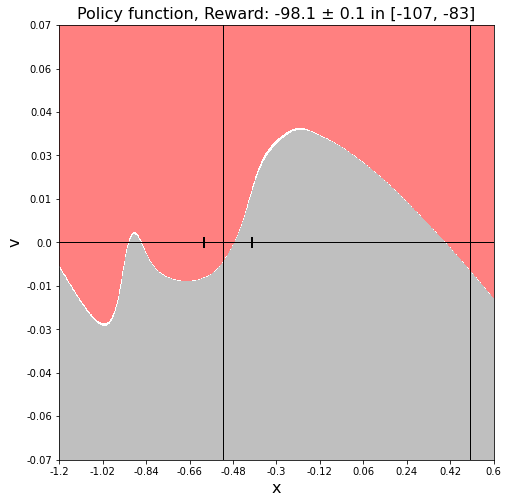

In [32]:
plot(pi, 'Policy function, Reward: -98.1 ± 0.1 in [-107, -83]', d_ticks=100, bins = (1001, 1001), bar=False, smooth = False)

In [ ]:
import datetime
  
state = {'info':      "MountainCar Reward:  -98.27 ± 0.1, std: 7, [-108, -83]",            # описание
         'date':      datetime.datetime.now(),   # дата и время
         'model' :    model.state_dict(),        # параметры модели
         'optimizer': optimizer.state_dict()}    # состояние оптимизатора
 
torch.save(state, 'MountainCar_2_128_128_1.98.2.pt')                    # сохраняем файл

<hr><hr>

# Policy-function with Softmax


In [ ]:
def dataset():
    X, Y = [], []
    pi = solver.pi
    for ix in range(1, solver.bins[0]-1):
        for iv in range(1, solver.bins[1]-1):
            a = pi[ix, iv]
            if a != -1:                
                  X.append( solver.state((ix, iv)).tolist() )
                  Y.append( int(pi[ix, iv]) )
    return X, Y


In [ ]:
solver.prev, solver.next = [], []    # clear memory

X, Y = dataset()
X, Y = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.int64)

print(X[-3:])
print(Y[-3:])

print(torch.min(Y), torch.max(Y), len(Y), torch.sum(Y == 1.), torch.sum( Y == 0.))

In [ ]:
import torch
import torch.nn as nn

gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(gpu)

## Network architecture

In [ ]:
nH = [32, 64]
model = nn.Sequential(
           nn.Linear(2, nH[0]),    
           nn.ReLU(),      
           nn.Linear(nH[0], nH[1]),  
           nn.ReLU(),         
           nn.Linear(nH[1], 3),  
           )      
model.to(gpu) 
print(gpu)

In [ ]:
loss      = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),   lr=0.1, momentum=0.8) 
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1 )

gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X = X.to(gpu)
Y = Y.to(gpu)

print(X.shape, Y.shape)
print(X.device, Y.device)

In [ ]:
def fit(model, X,Y, batch_size=1000, train=True):          
      model.train(train)                                 
      sumL, sumA, numB = 0, 0, int( len(X)/batch_size )  
       
      idx = torch.randperm( len(X) ).to(gpu)             
      X, Y = X[idx], Y[idx]      

      for i in range(0, numB*batch_size, batch_size):          
          xb = X[i: i+batch_size]                        
          yb = Y[i: i+batch_size]                        
              
          y = model(xb)                                  
          L = loss(y, yb)                                
  
          if train:                                      
              optimizer.zero_grad()                      
              L.backward()                               
              optimizer.step()                           
                                     
          sumL += L.detach().item()                       
          a = torch.argmax( torch.softmax(y.detach(), 1), 1 )
          sumA += (a == yb).float().mean()                
         
      return sumL/numB,  sumA/numB                        

In [ ]:
import time
model.to(gpu)
print( "before:      loss: %.3e accuracy: %.4f" %  fit(model, X,Y, train=False) )
 
beg = time.process_time()
epochs = 1000                                             
for epoch in range(epochs):                               
    L,A = fit(model, X, Y, batch_size=1000)               
      
    if (epoch and epoch % 10 == 0) or epoch == epochs-1:  
        print(f"epoch: {epoch:5d} loss: {L:.3e} accuracy: {A:.4f}   {time.process_time()-beg:.2f}s")   
        beg = time.process_time()

In [ ]:
def table(model, bins = (101, 101)):    
    pi = np.empty(bins)
    step = (solver.env.high-solver.env.low)/bins
    X = torch.empty((bins[0]*bins[1], 2), dtype=torch.float32)
    i = 0
    for ix in range(bins[0]):
        for iv in range(bins[1]):
            X[i] = torch.tensor(solver.env.low + (ix, iv)*step, dtype=torch.float32)
            i += 1

    print("model calc")
    with torch.no_grad():
        Y = model(torch.tensor(X, dtype=torch.float32))
        A = torch.argmax( torch.softmax(Y.detach(), 1), 1 )
    print("X:", X.shape, "Y:", Y.shape, "A:", A.shape)
    
    i, cnt = 0, 0
    for ix in range(bins[0]):
        for iv in range(bins[1]):            
            #probs = torch.softmax(Y[i], 0).numpy()     
            #pi[ix, iv] = np.random.choice([0,1,2], p=probs)  
            pi[ix, iv] = A[i]
            i += 1

        print(f"\rPolicy : {ix*100./bins[0]:3.0f}%", end="")
    return pi


pi = table(model.cpu(), (1001, 1001))

In [ ]:
plot(pi, 'Policy function', d_ticks=100, bins = (1001, 1001))

In [ ]:
def test(model, episodes = 10000, ticks=200, level = 0.05):
    env = gym.make("MountainCar-v0")
    rews = []
    for episode in range(episodes):
        obs =  env.reset()
        tot = 0
        for _ in range(ticks):
            with torch.no_grad():
                y = model(torch.tensor(obs, dtype=torch.float32))
                a = torch.argmax( torch.softmax(y, 0), 0 )
            action = a.item()

            obs, rew, done, _ = env.step(action)
            tot += rew

            if done:
                break

        rews.append(tot)
        if episode and episode % 100 == 0:
            mean, std = np.mean(rews), np.std(rews)
            print(f"\r{episode:5d}:  Reward: {mean:7.2f} ± {std/len(rews)**0.5:.1f}, std: {std:.0f}, min: {np.min(rews):.0f}  max: {np.max(rews):.0f}", end="")  

    mean, std = np.mean(rews), np.std(rews)
    print(f"\r{episode:5d}:  Reward: {mean:7.2f} ± {std/len(rews)**0.5:.1f}, std: {std:.0f}, min: {np.min(rews):.0f}  max: {np.max(rews):.0f}")  
            
    
test(model, level = 0.05)

In [ ]:
import datetime
  
state = {'info':      "MountainCar",            # описание
         'date':      datetime.datetime.now(),   # дата и время
         'model' :    model.state_dict(),        # параметры модели
         'optimizer': optimizer.state_dict()}    # состояние оптимизатора
 
torch.save(state, 'MountainCar_16_32_soft.9980.99.pt')                    # сохраняем файл